<a href="https://colab.research.google.com/github/sunnyanthony/diffusion_playground/blob/aml_project/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Process and Reverse Process

## Specific Prerequisites
* Markov Chain in Probability Graph Module
* U-Net

## Noise Process

$q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)$

$q(x_{1:t} | x_0) = \prod p(x_t|x_{t-1})$
### Reparametriation
$$
    \alpha_t = 1 - \beta_t \\
    \bar \alpha_t = \prod_{i=1}^t \alpha_i \\
    \epsilon \sim N(0, I)\\
    x_t = \sqrt{1-\beta_t}x_{t-1}+\sqrt{\beta_t}\epsilon\\
    = \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}\epsilon\\
    = \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_t\alpha_{t-1}}\epsilon\\
    = ... \\
    =\sqrt{\bar\alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon \\
    q(x_t | x_0) = N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I) \\
$$

## U-Net
We use it to predict noise in U-Net. Even if the U-Net could use to predict $x_0$ from $x_t$, the preformace is pretty bad.


## Denoising Process
$p_\theta(x_{t-1}|x_t)$ is reverse process of the noise process. In here, the model does not know $q(x_{t-1}|x_t)$ (not $q(x_t|x_{t-1})$). It's hard to calculate $q(x_{t-1}|x_t)$.
Hence, we guess the reverse distribution is almost like Gaussion distribution.
$$
  p_\theta(x_{t-1}|x_t) = N(x_{t-1};\mu_\theta(x_t,t), {\sum}_\theta(x_t,t))\\
  s.t.\ p_\theta(x_{0:T}) = p(x_T)\prod^T_t p_\theta(x_{t-1}|x_t)
$$
Therefore, we use deep learning to lean the $\mu$ and $\sum$ for the reverse distribution. The loss function is from cross-entropy of Markov chain of condition probability and it's similar to $L_{VAE}$.
$$
  L = \sum_t^T L_{t}\\
  L_t =  D_{KL}(q(x_t|x_{t+1}, x_0) \| p_\theta(x_{t}|x_{t+1}))\\
  L_0 = -ln\ p_\theta(x_0|x_1)\\
  L_T = D_{KL}(q(x_T, x_0) \| p_\theta(x_{T}))
$$
    
The mean and variance are $\tilde \mu(x_t, x_0) = \frac{\sqrt{1-\beta_{t-1}}x_{t}}{1-\bar \alpha_t}x_0+ \frac{\sqrt{\alpha_t}(1-\bar \alpha_{t-1})}{1-\bar \alpha_t}x_t$ and Var is $\tilde\beta_t I = \frac{(1-\bar \alpha_{t-1})}{1-\bar \alpha_t}\beta_t I$. And the $L_{t-1}$ approximates to $E_{x,\epsilon}[\frac{1}{2\|{\sum}_\theta\|_2^2}\|\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon) - \mu_\theta(x_t, t)\|_2^2]$.
However, it's still complicated. What's if we predict $\epsilon$ ?
$$
\mu(x_t, t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t)) = x_{t-1}\\
  L_{t-1} = E_{x_t, \epsilon}[\frac{\beta_t^2}{2\alpha_t(1-\bar \alpha_t)\|{\sum}_\theta\|_2^2}\|\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t}x_0 + \sqrt{1 - \bar \alpha_t}\epsilon, t)\|_2^2]
$$

### Algorithms
* Training
  0. loop
  1. $x_0 \sim q(x_0)$
  2. $t \sim U(0,T)$
  3. $\epsilon \sim N(0,I)$
  4. $\theta = \theta + \nabla_\theta MSE(\epsilon, \epsilon_\theta(\sqrt{\bar \alpha_t}x_0 + \sqrt{1 - \bar \alpha_t}\epsilon, t))$
* Sampling
  1. $x_T \sim N(0, I)$
  2. for loop in steps $t\ in\ [T:0]$
  3. $\ \ x_{t-1}=\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t)) + \sigma_t Z$
  4. return $x_0$    

**$\epsilon_\theta$ is `U-Net` neual network model.**

### Embedding
1. Use `sinusoidal positione mbedding` to define the postion of the noise in the sequence.

In [ ]:
from enum import Enum, auto
class Beta():
  class schedule(Enum):
    linear = auto()
    cosin = auto()

  def __init__(self, start, end, times):
    """
    diffusion rate scheduler
    """
    self.start = start
    self.end = end
    self.times = times
    if not all([0.0 <= self.start < 1.0, 0.0 <= self.end < 1.0, self.start < self.end]):
      raise ValueError("Beta should between 0.0 and 1.0")

  def get_schedule(self, typeof: schedule):
    if typeof == Beta.schedule.linear:
      return np.linspace(self.start, self.end, self.times)
    elif typeof == Beta.schedule.cosin:
      """
      Alex Nichol, Prafulla Dhariwal (2021), Improved Denoising Diffusion Probabilistic Models
      \beta = 1 - \frac{\bar \alpha_t}{\bar \alpha_{t-1}}
      """
      import math
      def bar_alpha(t, s = 0.008):
        """
        f = cos(\frac{t/T+s}{1+s} \frac{\pi}{2})^2,\ where\ s=0.008
        """
        return (math.cos((t + s) / (1+s) * math.pi / 2) ** 2)
      clip_beta = 0.999
      return np.array([min(1 - bar_alpha((i) / self.times) / bar_alpha( (i-1) / self.times), clip_beta) for i in range(1, self.times+1)])
    return None

In [ ]:
from IPython.utils.frame import extract_vars_above
import numpy as np
import torch


class GaussianDiffusion():
  """
  q is forward process
  p is backward process
  """

  def __init__(self,
               beta: Beta,
               times = None,
               schedulerType = Beta.schedule.linear):
    """
    q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)
    q(x_{1:t} | x_0) = \prod p(x_t|x_{t-1})

    Reparametriation: for the close-form representation
    \alpha_t = 1 - \beta_t
    \bar \alpha_t = \prod_{i=1}^t \alpha_i
    q(x_t|x_{t-1}) = \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon
    q(x_t | x_0) = N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I)
    """
    self.B = beta
    self.betas = self.B.get_schedule(schedulerType)
    if self.betas is None:
      raise Exception("please check the schedule type")
    self.times = times
    self.alphas = 1 - self.betas
    self.alphas_hat = np.cumprod(self.alphas, axis=0)

    self.alphas_prodprev = np.append(1.0, self.alphas_hat[:-1])

    # For \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon
    # and N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I)
    # that shared the \sqrt{\bar \alpha_t} and \sqrt{1-\bar \alpha_t}
    self.firstpart_q_alphas_hat = np.sqrt(self.alphas_hat)
    self.secondpart_q_alphas_hat = np.sqrt(1.0 - self.alphas_hat)

  def noise(self, x_0):
    """
    standard distribution sampling
    """

    if torch. is_tensor(x_0):
      return torch.randn_like(x_0)
    else:
      return np.random.randn(*x_0.shape)

  def q_sample(self, x_0, t, noise=None):
      """
      Forward: noising
      return x_t
      """
      if noise is None:
          noise = self.noise(x_0) # epsilon
      return self.firstpart_q_alphas_hat[t] * x_0 \
          + self.secondpart_q_alphas_hat[t] \
          * noise



  def p_sample(self, predictor, x_t, t, printing=False):
    """
    TODO: change to torch.tensor
    """
    """
    x_{t-1}=\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t)) + \sigma_t Z
    """
    if self.betas is None:
      raise Exception("please create instance with bets")
    betas_t = torch.Tensor([self.betas[t]]).to(x_t.device)

    # \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t))
    x_t_1 = torch.sqrt(1.0 / torch.Tensor([self.alphas[t]]).to(x_t.device)) * \
          ( torch.Tensor(x_t).to(x_t.device) - \
          ( betas_t / torch.Tensor([self.secondpart_q_alphas_hat[t]]).to(x_t.device)) * predictor(x_t, t))
    if printing:
      print(f"{predictor(x_t, t)=}")
      print(f"{betas_t / torch.Tensor([self.secondpart_q_alphas_hat[t]]).to(x_t.device) * predictor(x_t, t)}")

    # \sigma_t Z
    alphas_hat_1 = nn.functional.pad(torch.Tensor([self.alphas_hat[:-1]]).to(x_t.device), (1, 0), value=1.0)
    temp = torch.Tensor([self.betas]).to(x_t.device) * (1.0 - alphas_hat_1) / (1.0 - torch.Tensor([self.alphas_hat]).to(x_t.device))
    temp = temp[0][t]
    temp = torch.sqrt(temp)
    extra = temp * torch.randn_like(x_t) if t > 0 else 0
    if printing:
      print(extra)
      print(x_t_1 + extra)

    return x_t_1 + extra


  def loss_function(self, x_0, epsilon_theta_module: torch.nn.Module, steps = 100, t = None, epsilon = None):
    """
    E_{x,\epsilon}[const*\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon) - \mu_\theta(x_t, t)\|_2^2]
    const = \frac{1}{2\|{\sum}_\theta\|_2^2}\|
    => \hat E_{x,\epsilon}[\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon) - \mu_\theta(x_t, t)\|_2^2]
    """
    t = torch.randint(0, steps, (x_0.shape[0],), dtype=torch.long) if t is None else t
    epsilon = torch.randn_like(x_0, device=x_0.device) if epsilon is None else epsilon
    xt = self.q_sample(x_0, t, noise=epsilon)
    xt.to(next(epsilon_theta_module.parameters()).device)
    eps_theta = epsilon_theta_module(xt, t)
    loss = torch.nn.MSELoss()
    ret = loss(eps_theta, epsilon) # it would gradient MSE for SGD
    return ret

In [ ]:
from torch import nn
import math
class UNet(nn.Module):
  """
  please please please read Olaf Ronneberger, Philipp Fischer, Thomas Brox (2015),
  U-Net: Convolutional Networks for Biomedical Image Segmentation
  The structure is downsampling and upsampling, and connecting to each blocks.
  """

  class TimeEmbedded(nn.Module):
    def __init__(self, dim):
      super().__init__()
      self.dim = dim
  
    def forward(self, x):
      """
      Vaswani et al. (2017)
      PE_(pos,2i) = sin(pos/10000^(2i/d_model))
      PE_(pos,2i+1) = cos(pos/10000^(2i/d_model))

      According to https://huggingface.co/blog/annotated-diffusion, 
      https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL#scrollTo=buW6BaNga-XH,
      and https://pytorch.org/tutorials/beginner/transformer_tutorial.html
      I don't know why we need to logarithmize the number. 
      """
      temp_term = -math.log(10000) / (self.dim//2 - 1) # log (10000^(2 / dim)) = (log(10000)*2) / dim
      div_term = torch.exp(torch.arange(start=0, end = self.dim, step=2, device=x.device) * temp_term)
      embedded = x[:, None] * div_term[None,:]
      return torch.cat((embedded.sin(), embedded.cos()), dim = -1)

  class Conv3x3ReLU(nn.Module):
    def __init__(self, insize, out, time_dim, padding = 1, dim = 2, stride=1, bias = True):
      super().__init__()

      class_nd = getattr(nn, f"Conv{dim}d") # exception if not found
      self.conv0 = class_nd( in_channels = insize, out_channels = out,
                            kernel_size = 3, padding = padding, bias = bias,
                            stride = stride)
      self.relu0 = nn.ReLU(inplace=True)
      self.conv1 = class_nd( in_channels = out, out_channels = out,
                            kernel_size = 3, padding = padding, bias = bias,
                            stride = stride)
      self.relu1 = nn.ReLU(inplace=True)

      # avoid the output exp...
      self.bnorm0 = nn.BatchNorm2d(out)
      self.bnorm1 = nn.BatchNorm2d(out)

      # refer to openai/guided-diffusion
      self.emb_layers = nn.Sequential(
            nn.Linear(time_dim,out),
            nn.SiLU(),
            nn.Linear(out,out),
            ) if time_dim else None

    def forward(self, x, time_embedded = None):
      for i in range(2):
        if i == 1 and time_embedded is not None and self.emb_layers:
          e = self.emb_layers(time_embedded)
          while len(e.shape) < len(x.shape):
            e = e[..., None]
          x = x + e
        # normalizatin should be done before relu
        x = getattr(self, f"relu{i}")(getattr(self, f"conv{i}")(x))
        x = getattr(self, f"bnorm{i}")(x)
      return x

  class Conv3x3GeLU(Conv3x3ReLU):
    def __init__(self, insize, out, time_dim, padding = 1, dim = 2, stride=1, bias = True):
      super().__init__(insize, out, time_dim, padding, dim, stride, bias)
      self.relu0 = torch.nn.GELU()
      self.relu1 = torch.nn.GELU()

  class MaxPooling2x2(nn.Module):
    def __init__(self, dim = 2):
      super().__init__()
      maxpool_nd = getattr(nn, f"MaxPool{dim}d")
      self.pooling = maxpool_nd(kernel_size = 2, stride=2) # stride would as same as kernel which would sample to half of the data

    def forward(self, x):
      return self.pooling(x)

  class UpPooling(nn.Module):
    def __init__(self, insize, out, time_dim,
                 dim = 2,
                 mode = None,
                 kernelsize=3,
                 kernelsize_up = 2,
                 stride = 2,
                 padding = 0,
                 bias=False):
      super().__init__()
      class_nd = getattr(nn, f"Conv{dim}d")
      mid = int(2**((np.log2(insize)  + np.log2(out)) // 2))
      if mode:
        self.sample = nn.Sequential(
            nn.Upsample(mode=mode, scale_factor=2),
            class_nd( mid, out, kernel_size=2, groups=1, stride=1)
            )
      else:
        uplearnableclass = getattr(nn, f"ConvTranspose{dim}d")
        self.sample = uplearnableclass(in_channels=mid, out_channels=out, kernel_size=kernelsize_up,
                                       stride=stride+1, padding=padding-1)
      self.conv = class_nd( in_channels=insize, out_channels=mid,
                            kernel_size=kernelsize, bias=bias, stride=stride, padding=padding)
      
      # refer to openai/guided-diffusion
      self.emb_layers = nn.Sequential(
            nn.Linear(time_dim, out),
            nn.SiLU(),
            nn.Linear(out, out*4),
            ) if time_dim else None

      self.relu1 = nn.ReLU(inplace=True)
      self.bnorm1 = nn.BatchNorm2d(mid)
      self.relu2 = nn.ReLU(inplace=True)
      self.bnorm2 = nn.BatchNorm2d(out)


    def forward(self, x, time_embedded = None):
      if time_embedded is not None and self.emb_layers:
        e = self.emb_layers(time_embedded)
        while len(e.shape) < len(x.shape):
            e = e[..., None]
        x = x + e
      y = self.bnorm1(self.relu1(self.conv(x)))
      return self.bnorm2(self.relu2(self.sample(y)))

  def __init__(self, input_size, out_size, features, time_dim=None, bias = True):
    super().__init__()

    self.time_embedding = nn.Sequential(
        self.TimeEmbedded(time_dim),
        nn.Linear(time_dim, time_dim),
        nn.SiLU(),
    ) if time_dim else None

    self.inlayer = self.Conv3x3GeLU(input_size, features, time_dim)

    self.maxpool = self.MaxPooling2x2()

    self.bottom = self.Conv3x3ReLU(features*(2**(4)), features*(2**5), time_dim)
    self.up = self.UpPooling(features*(2**5), features*(2**(4)), \
                                                  time_dim, kernelsize = 3, bias = bias, \
                                                  stride = 1, padding=1)


    self.downlayer = nn.ModuleList([self.Conv3x3GeLU(features*(2**(i)), features*(2**(i+1)), time_dim) \
                                  for i in range(4)])

    self.outlayer = nn.ModuleList([self.UpPooling(features*(2**i), features*(2**(i-2)), \
                                                  time_dim, kernelsize = 3, bias = bias, \
                                                  stride = 1, padding=1) \
                                  for i in range(5, 1, -1)])

    self.conv1x1 = nn.Conv2d( in_channels = features, out_channels = out_size,
                            kernel_size = 3, bias = bias, stride = 1, padding=1)
    
  def forward(self, x, timestamp=None):

    time_position_embedded = self.time_embedding(timestamp) if self.time_embedding and timestamp else None

    residential = []
    x = self.inlayer(x, time_position_embedded)
    for i, dl in enumerate(self.downlayer):
      x = dl(self.maxpool(x), time_position_embedded)
      residential.append(x)

    out = self.bottom(self.maxpool(x))
    out = self.up(out)

    for i, ol in enumerate(self.outlayer):
      merge = torch.cat((out, residential[len(residential) - i - 1]), dim=1)
      out = ol(merge, time_position_embedded)
    out = self.conv1x1(out)
    return out


In [ ]:
from google.colab import drive
import sys

drive.mount('/content/gdrive/')
data_dir = '/content/gdrive/MyDrive/testdata/cityscapes_data'

Mounted at /content/gdrive/


In [ ]:

import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
from skimage.util import random_noise


train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")

In [ ]:

#  Copyright https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch
#  This block is copy from kaggle to load the test images.
#  torchvision.datasets.Cityscapes is not workable on the dataset from kaggle
#
#  The authors use kmean to get the different layer of image to identify the segmentation
#  for the target.

class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, num_items = 1000, num_classes = 10, image_x = 256,
                 image_y = 256, original_image_width = 256):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.num_classes = num_classes
        self.label_model = KMeans(n_clusters=num_classes, n_init=10)
        color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
        self.label_model.fit(color_array)
        self.x = image_x
        self.y = image_y
        self.split_y = original_image_width
        self.noise_type_num = 1

    def __len__(self):
        return len(self.image_fns) * (self.noise_type_num + 1)
    
    def __getitem__(self, index):
        method = index // len(self.image_fns)
        index %= len(self.image_fns)
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        # use k-mean to get the label
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(self.x, self.y)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        """
        augement cityscape with same label_class
        """
        if method == 0:
            pass
        # Gaussian Noise
        elif method == 1:
            cityscape = torch.tensor(random_noise(cityscape, mode='gaussian', mean=0, var=0.005, clip=True))

        # Salt and pepper noise:
        elif method == 2:
            cityscape = torch.tensor(random_noise(cityscape, mode='s&p', clip=False))

        # Poisson noise:
        elif method == 3:
            cityscape = torch.tensor(random_noise(cityscape.clip(1e-5), mode='poisson'))

        # Speckle noise:
        elif method == 4:
            cityscape = torch.tensor(random_noise(cityscape, mode='speckle'))
        
        return cityscape.float(), label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :self.split_y, :], image[:, self.split_y:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

noise_dataset = CityscapeDataset(train_dir, num_classes=10)
noise_data_loader = DataLoader(noise_dataset, batch_size=1)

In [ ]:
class DiffusionCityscapeDataset(CityscapeDataset):
    
  def __init__(self, image_dir, num_items = 1000, num_classes = 10, image_x = 256,
              image_y = 256, original_image_width = 256, scheduler = Beta.schedule.cosin,
              steps = 1, scheduler_end = 0.02, scheduler_start = 0.0001):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.num_classes = num_classes
    self.label_model = KMeans(n_clusters=num_classes, n_init=10)
    color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
    self.label_model.fit(color_array)
    self.x = image_x
    self.y = image_y
    self.split_y = original_image_width
    self.diffusion_model = GaussianDiffusion(Beta(scheduler_start, scheduler_end, steps+1), \
                                              schedulerType=scheduler)
    self.steps = steps
    self.noise_type_num = 1
  
  def __getitem__(self, index):
    mode = index % 2
    index = index//2
    index %= len(self.image_fns)
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert('RGB')
    image = np.array(image)
    cityscape, label = self.split_image(image)
    # use k-mean to get the label
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(self.x, self.y)
    cityscape = self.transform(cityscape, mode)
    label_class = torch.Tensor(label_class).long()
    
    return cityscape, label_class
  
  def transform(self, image, mode):
    x = super().transform(image)
    return x if mode == 0 else self.diffusion(x)

  def diffusion(self, x):
    noise = self.diffusion_model.noise(x)
    noised_img = self.diffusion_model.q_sample(x, self.steps, noise=noise)

    def _model(_, t):
      if t >= 1:
        return self.diffusion_model.q_sample(x, t, noise=noise) - \
            self.diffusion_model.q_sample(x, t-1, noise=noise)
      else:
        return noise

    for i in range(0,self.steps+1)[::-1]:
      t = torch.tensor([i])
      noised_img = self.diffusion_model.p_sample(_model, noised_img, t)
    return noised_img


diffusionDataset = DiffusionCityscapeDataset(train_dir, num_classes=10)
diffusion_data_loader = DataLoader(diffusionDataset, batch_size=1)

In [ ]:
# for validation
class _CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, num_items = 1000, num_classes = 10, image_x = 256,
                 image_y = 256, original_image_width = 256):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.num_classes = num_classes
        self.label_model = KMeans(n_clusters=num_classes, n_init=10)
        color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
        self.label_model.fit(color_array)
        self.x = image_x
        self.y = image_y
        self.split_y = original_image_width

    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        # use k-mean to get the label
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(self.x, self.y)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :self.split_y, :], image[:, self.split_y:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

vailation_dataset = _CityscapeDataset(val_dir, num_classes=10)
vailation_data_loader = DataLoader(vailation_dataset, batch_size=1)
default_dataset = _CityscapeDataset(train_dir, num_classes=10)
default_data_loader = DataLoader(default_dataset, batch_size=1)

## Training

In [ ]:
from tqdm import tqdm
# hyperparameters
learning_rate = 1e-3
#steps = 100
hidden_features = 16 # use less features to speed up the training and make the augmentation to cover it
epochs = 20

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else "mps" \
                    if torch.backends.mps.is_available() else 'cpu')

def training(classes,
             data_loader,
             vailation_data_loader,
             lossrate: List,
             accurancy: List,
             hidden_features,
             learning_rate,
             epochs,
             PATH_PT):
  model = UNet(3, classes, hidden_features)
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  for epoch in tqdm(range(epochs)):
    model.train()
    for img, t in data_loader:
      img = img.to(device)
      t = t.to(device)
      optimizer.zero_grad()
      predict = model(img)
      loss = criterion(predict, t)
      loss.backward()
      optimizer.step()

    model.eval()
    lossrate.append([])
    accurancy.append([])
    with torch.no_grad():
      for img, t in vailation_data_loader:
        img = img.to(device)
        t = t.to(device)
        predict = model(img)
        loss = criterion(predict, t)
        lossrate[-1].append(loss.item())
        # get the max probability of the classes 
        preds = torch.argmax(predict, 1)
        accurancy[-1].append(preds.eq(t).float().mean().item())
  torch.save(model.state_dict(), PATH_PT)

def plot(array, color='b', label='Loss', title="Loss rate"):
  # plot loss rates
  plt.figure(figsize=(8,5))

  plt.plot(range(len(array)), [sum(xs) / len(xs) for xs in array], \
           linestyle='--', marker='o', color=color, label=label)

  plt.legend(loc='best', fontsize=13)
  plt.xlabel("$Iterations$",fontsize=14)
  plt.ylabel(f"${label}$",fontsize=14)
  plt.title(title,fontsize=15)

### Default Testing without Augmentation

In [ ]:
lossrate = []
accurancy = []

training(classes=vailation_dataset.num_classes,
        data_loader=vailation_data_loader,
        vailation_data_loader=vailation_data_loader,
        lossrate=lossrate,
        accurancy=accurancy,
        hidden_features=hidden_features,
        learning_rate=learning_rate,
        epochs=epochs,
        PATH_PT=data_dir+'/default_10_class.pt')

100%|██████████| 20/20 [04:47<00:00, 14.37s/it]


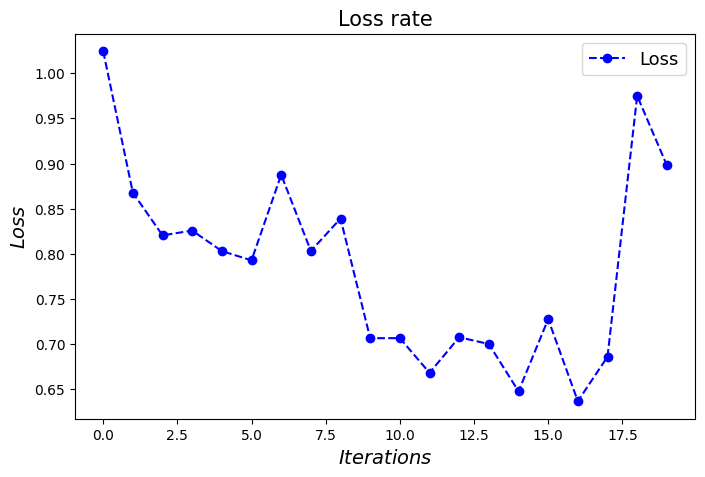

In [ ]:
# plot loss rates
plot(lossrate)

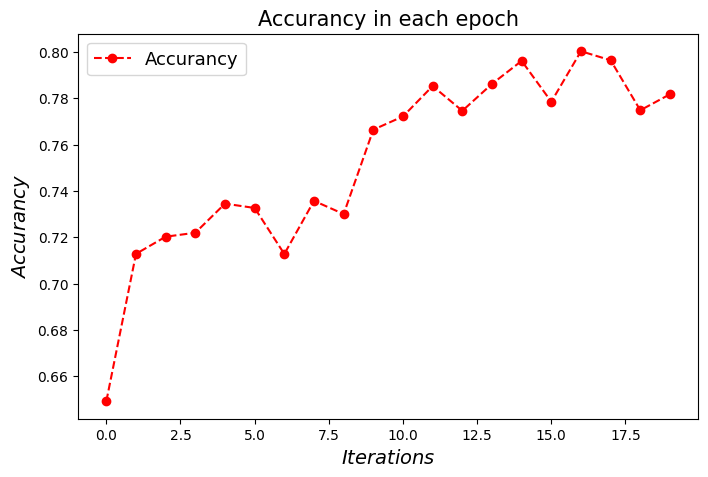

In [ ]:
# plot accuracy rates
plot(accurancy, color='r', label='Accurancy', title="Accurancy in each epoch")

### Noise Augementations

In [ ]:
noise_lossrate = []
noise_accurancy = []

training(classes=noise_dataset.num_classes,
        data_loader=noise_data_loader,
        vailation_data_loader=vailation_data_loader,
        lossrate=noise_lossrate,
        accurancy=noise_accurancy,
        hidden_features=hidden_features,
        learning_rate=learning_rate,
        epochs=epochs,
        PATH_PT=data_dir+'/noise_10_classes_.pt')

100%|██████████| 20/20 [41:56<00:00, 125.82s/it]


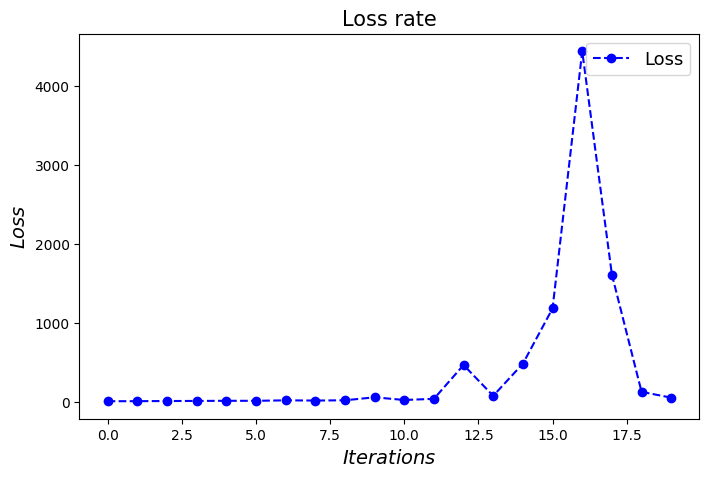

In [ ]:
# plot loss rates
plot(noise_lossrate)

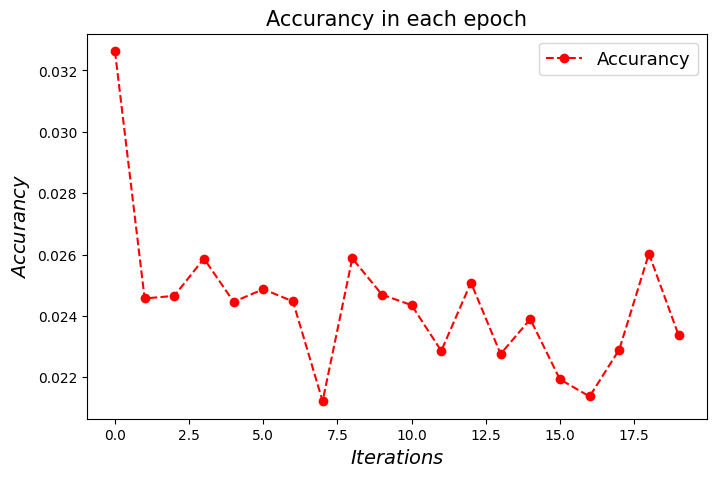

In [ ]:
# plot accuracy rates
plot(noise_accurancy, color='r', label='Accurancy', title="Accurancy in each epoch")

### Diffusion Augementation

In [ ]:
diff_lossrate = []
diff_accurancy = []

training(classes=diffusionDataset.num_classes,
        data_loader=diffusion_data_loader,
        vailation_data_loader=vailation_data_loader,
        lossrate=diff_lossrate,
        accurancy=diff_accurancy,
        hidden_features=hidden_features,
        learning_rate=learning_rate,
        epochs=epochs,
        PATH_PT=data_dir+'/diffusion_10_classes.pt')

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-4-6eb712a6a2ba>:85: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  alphas_hat_1 = nn.functional.pad(torch.Tensor([self.alphas_hat[:-1]]).to(x_t.device), (1, 0), value=1.0)
100%|██████████| 20/20 [42:11<00:00, 126.59s/it]


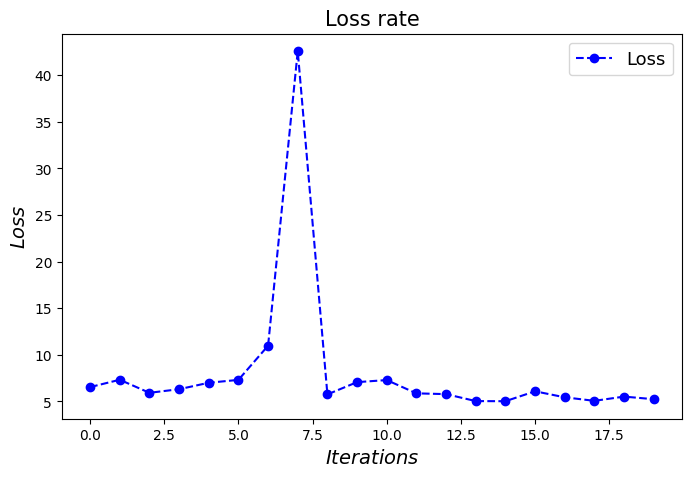

In [ ]:
# plot loss rates
plot(diff_lossrate)

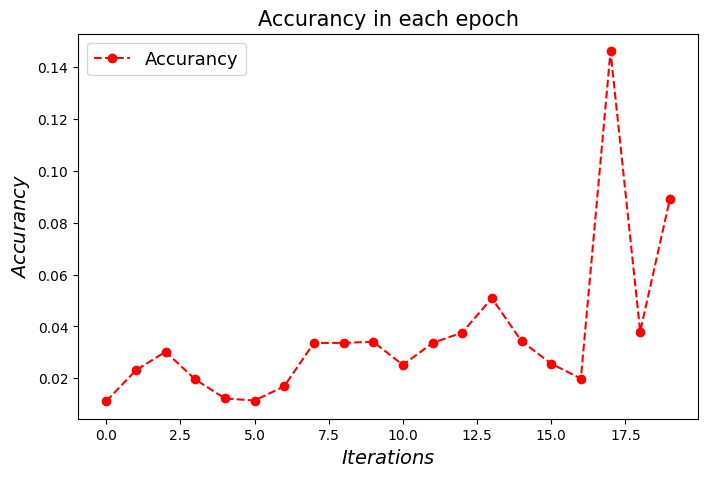

In [ ]:
# plot accuracy rates
plot(diff_accurancy, color='r', label='Accurancy', title="Accurancy in each epoch")

## different steps in the diffusion process

In [ ]:
stepslist = [2**i for i in range(8)]
diff_accurancy_steps = []
for steps in stepslist:
  diffusionDataset = DiffusionCityscapeDataset(train_dir, num_classes=10, steps=steps)
  diffusion_data_loader = DataLoader(diffusionDataset, batch_size=1)
  diff_lossrate_c = []
  diff_accurancy_c = []
  training(classes=diffusionDataset.num_classes,
        data_loader=diffusion_data_loader,
        vailation_data_loader=vailation_data_loader,
        lossrate=diff_lossrate_c,
        accurancy=diff_accurancy_c,
        hidden_features=hidden_features,
        learning_rate=learning_rate,
        epochs=epochs,
        PATH_PT=data_dir+'/diffusion.pt')
  diff_accurancy_c = [sum(xs) / len(xs) for xs in diff_accurancy_c]
  diff_accurancy_steps.append(max(diff_accurancy_c))

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-4-6eb712a6a2ba>:85: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  alphas_hat_1 = nn.functional.pad(torch.Tensor([self.alphas_hat[:-1]]).to(x_t.device), (1, 0), value=1.0)
  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# plot accuracy rates
plt.figure(figsize=(8,5))

plt.plot(range(len(diff_accurancy_steps)), diff_accurancy_steps, \
          linestyle='--', marker='o', color='r', label='Accurancy')
plt.legend(loc='best', fontsize=13)
plt.xlabel("$Steps (Timestamp)$",fontsize=14)
plt.ylabel(f"$Accurancy$",fontsize=14)
plt.title('Accurancy in Different Steps',fontsize=15)

### Show all accurancy and loss

In [ ]:
def plotall(result1, result2, result3, label='Loss', title="Loss rate"):
  # plot loss rates
  plt.figure(figsize=(8,5))
  array1, label1 = result1
  array2, label2 = result2
  array3, label3 = result3

  plt.plot(range(len(array1)), [sum(xs) / len(xs) for xs in array1], \
           linestyle='--', marker='o', color='r', label=label1)
  plt.plot(range(len(array2)), [sum(xs) / len(xs) for xs in array2], \
          linestyle='--', marker='o', color='b', label=label2)
  plt.plot(range(len(array3)), [sum(xs) / len(xs) for xs in array3], \
        linestyle='--', marker='o', color='g', label=label3)

  plt.legend(loc='best', fontsize=13)
  plt.xlabel("$Iterations$",fontsize=14)
  plt.ylabel(f"${label}$",fontsize=14)
  plt.title(title,fontsize=15)

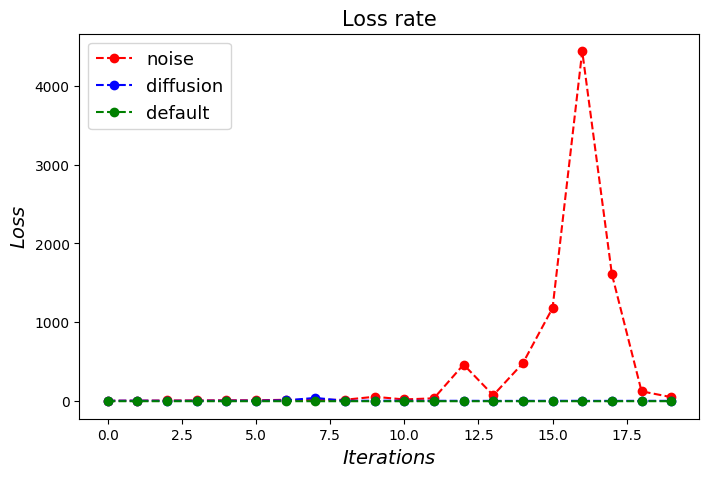

In [ ]:
plotall((noise_lossrate, "noise"), (diff_lossrate, "diffusion"), (lossrate, "default"))

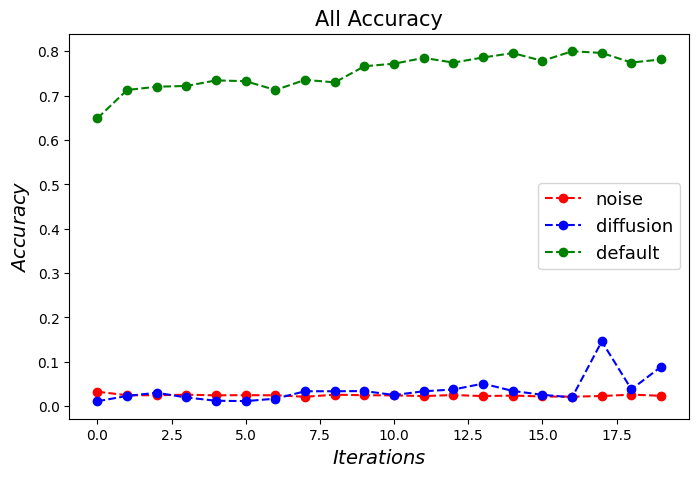

In [ ]:
plotall((noise_accurancy, "noise"), (diff_accurancy, "diffusion"), (accurancy, "default"), "Accuracy", "All Accuracy")

## Show the sampling pictures

In [ ]:
def print_result(data_loader_val, path, classes):
  #  Copyright https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch
  #  This block is copy from kaggle to load the validation images and show the prediction images.

  model = UNet(3, classes, hidden_features)
  model.load_state_dict(torch.load(path, map_location=torch.device(device)))
  model.eval()
  X, Y = next(iter(data_loader_val))
  Y_pred = model(X)
  #print(Y_pred.shape)
  Y_pred = torch.argmax(Y_pred, dim=1)
  #print(Y_pred.shape)
  inverse_transform = transforms.Compose([
      transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
  ])
  fig, axes = plt.subplots(1, 3, figsize=(3*5, 10*5))

  landscape = inverse_transform(X[0]).permute(1, 2, 0).cpu().detach().numpy()
  label_class = Y[0].cpu().detach().numpy()
  label_class_predicted = Y_pred[0].cpu().detach().numpy()
  axes[0].imshow(landscape)
  axes[0].set_title("Landscape")
  axes[1].imshow(label_class)
  axes[1].set_title("Label Class")
  axes[2].imshow(label_class_predicted)
  axes[2].set_title("Label Class - Predicted")

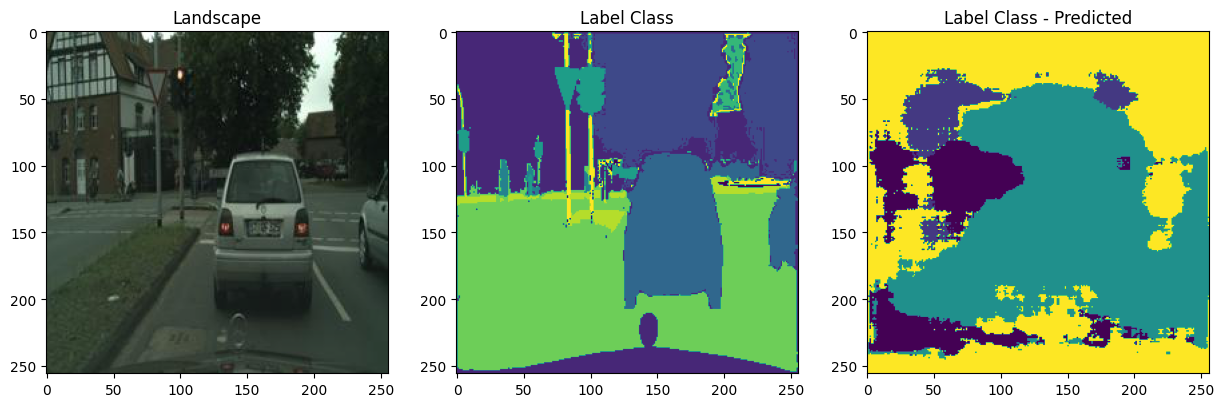

In [ ]:
print_result(vailation_data_loader, path=data_dir+'/diffusion_10_classes.pt', classes=vailation_dataset.num_classes)

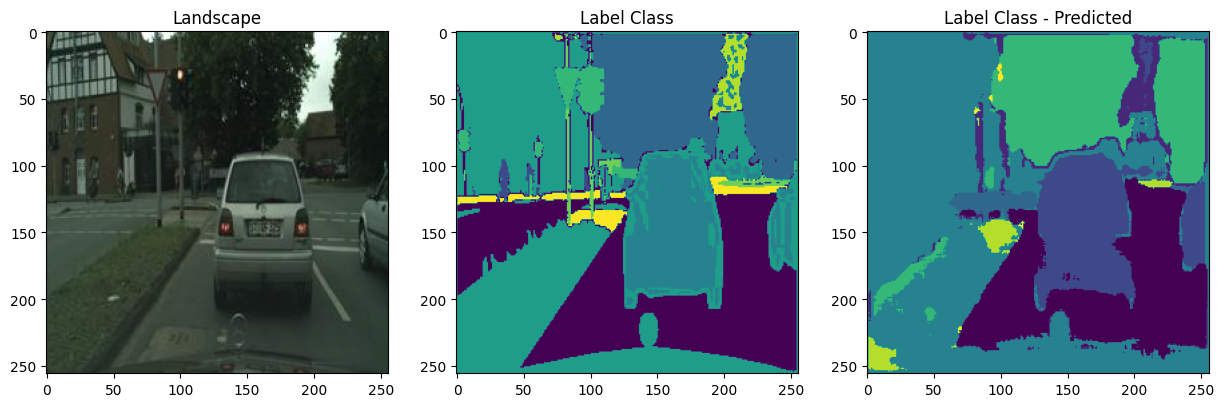

In [ ]:
print_result(vailation_data_loader, path=data_dir+'/noise10classes.pt', classes=vailation_dataset.num_classes)

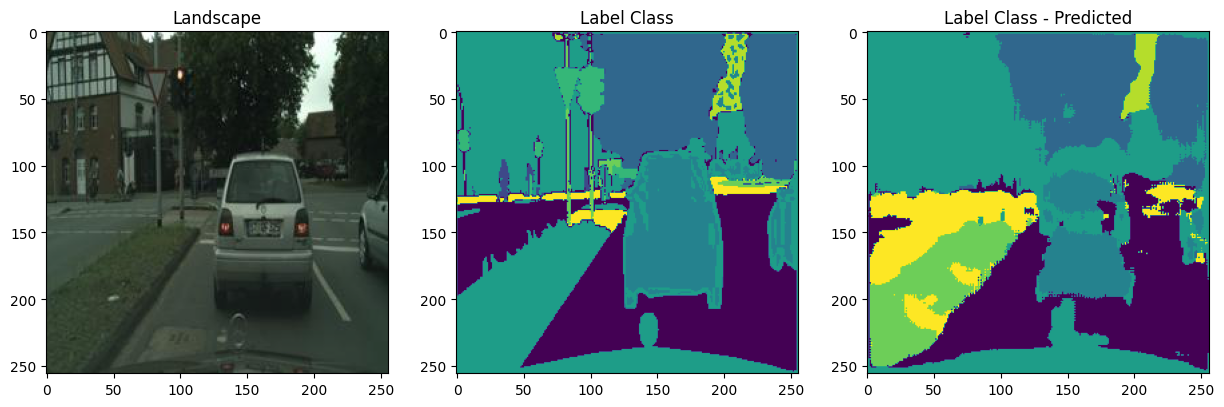

In [ ]:
print_result(vailation_data_loader, path=data_dir+'/default_10class.pt', classes=vailation_dataset.num_classes)